# Multi-Agent Workflow Demo

This notebook demonstrates how to load the LangGraph `app`, visualize the graph, and run the workflow with real-time progress updates.

## 1. Environment Setup

In [1]:
import os
import sys
from pathlib import Path
from IPython.display import Image, display

from bsm_multi_agents.graph.agent_graph import build_app, get_graph_image
from bsm_multi_agents.graph.state import WorkflowState

cwd = Path.cwd()
project_path = cwd.parent.parent
project_path

PosixPath('/Users/yifanli/Github/model_doc_automation/TooTwo_mcp')

## 2. Visualize Workflow

We can see the internal structure of our multi-agent system.

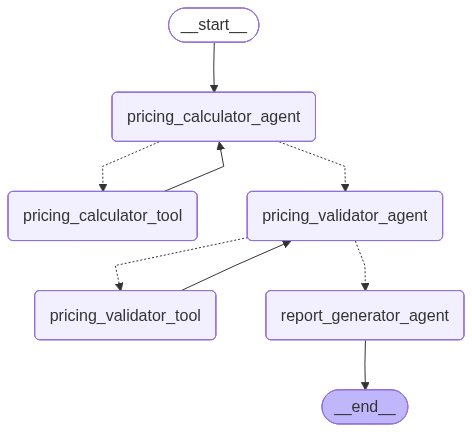

In [2]:
app = build_app()
display(Image(get_graph_image(app)))

## 3. Run Workflow with Progress Streaming

We use `app.stream()` to iterate through the execution steps. The nodes will print their status directly to the output.

In [3]:
# Initial State Setup
csv_file_path = str(project_path / "data/input/dummy_options_small.csv")
output_dir = str(project_path / "data/cache")
server_path = str(project_path / "src/bsm_multi_agents/mcp/server.py")
local_tool_folder_path = os.path.join(project_path, "src/bsm_multi_agents/tools")
final_report_path = str(project_path / "data/output/final_report.docx")

initial_state = WorkflowState(
    csv_file_path=csv_file_path,
    output_dir=output_dir,
    server_path=server_path,
    local_tool_folder_path=local_tool_folder_path,
    final_report_path=final_report_path,
    errors=[],
    messages=[],
    # "remaining_steps": 10,
)

config = {"configurable": {"thread_id": "demo_thread_1"}}

print("Starting Multi-Agent Workflow...\n")

final_state = app.invoke(
    initial_state,
    config=config,
    recursion_limit=5
)


# for chunk in app.stream(initial_state, config=config, stream_mode="updates"):
#     # pass
#     for node_name, updates in chunk.items():
#         print(f"Node Completed: [{node_name}]")
#         for key, value in updates.items():
#             if key == "messages" and value:
#                 last_msg = value[-1]
#                 print(f"   - update {key}: {type(last_msg).__name__}")
#             else:
#                 print(f"   - update {key}: {value}")
    

print("\nWorkflow Complete.")

Starting Multi-Agent Workflow...


>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: ['calculate_greeks_to_file']

>>> [Pricing Calculator Tool] Executing tool calls...
>>> [Pricing Calculator Tool] Executing tool calls: calculate_greeks_to_file

>>> [Pricing Calculator Agent] Starting planning...
>>> [Pricing Calculator Agent] Decide to use tools: []

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Validator Agent] Decide to use tools: ['validate_greeks_to_file', 'run_sensitivity_test_to_file', 'run_gamma_positivity_test_to_file']

>>> [Pricing Validator Tool] Executing validation calls...
>>> [Pricing Validator Tool] Executing tool calls: validate_greeks_to_file
>>> [Pricing Validator Tool] Executing tool calls: run_sensitivity_test_to_file
>>> [Pricing Validator Tool] Executing tool calls: run_gamma_positivity_test_to_file

>>> [Pricing Validator Agent] Starting validation planning...
>>> [Pricing Valid

## 4. Check Results

In [4]:
final_state = app.get_state(config).values
if final_state.get("errors"):
    print("Errors:", final_state["errors"])
else:
    print("Final Report Path:", final_state.get("final_report_path"))
    if os.path.exists(final_state.get("final_report_path", "")):
        print("File successfully generated!")

Final Report Path: /Users/yifanli/Github/model_doc_automation/TooTwo_mcp/data/output/final_report.docx
